In [1]:
# 準備
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from IPython import display

# 実験に使うデータ数
n_samples = 2000

# シードの固定
random.seed(31415)
np.random.seed(31415)

In [2]:
# 以下のコードはデータのダウンロードを伴うため、少々時間がかかる
from sklearn import datasets

X_org, y_org = datasets.fetch_openml(
    "mnist_784", return_X_y=True, data_home="./mnist", parser="auto"
)
X_org = np.array(X_org / 255.0, dtype="double")
y_org = np.array(y_org, dtype="uint8")

In [3]:
from sklearn import model_selection

X, X_test, y, y_test = model_selection.train_test_split(
    X_org, y_org, train_size=60000, test_size=10000, shuffle=True
)

In [4]:
text = f"""
なお、今回は計算時間の短縮のために、先頭{n_samples:d}個のデータだけを使って、以下の実験を行う。
"""
display.Markdown(text)


なお、今回は計算時間の短縮のために、先頭2000個のデータだけを使って、以下の実験を行う。


In [5]:
X, y = X[:n_samples], y[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

In [6]:
from sklearn.preprocessing import StandardScaler

# スケーリングパラメータの計算
scaler = StandardScaler()
scaler.fit(X)

# データのスケーリング
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# 識別モデルの構築
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [8]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("knn: acc(train)={:.2f}%".format(acc_train))

knn: acc(train)=85.05%


In [9]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("knn: acc(test)={:.2f}%".format(acc_test))

knn: acc(test)=84.90%


In [10]:
from sklearn.linear_model import LogisticRegression

# 訓練モデルの構築
lr_params = {"tol": 1.0e-2, "max_iter": 5000, "solver": "lbfgs"}
clf = LogisticRegression(**lr_params)
clf.fit(X, y)

LogisticRegression(max_iter=5000, tol=0.01)

In [11]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Logistic: acc(train)={:.2f}%".format(acc_train))

Logistic: acc(train)=100.00%


In [12]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Logistic: acc(test)={:.2f}%".format(acc_test))

Logistic: acc(test)=87.75%


In [13]:
# 単純なバギングの実装例
n_bootstrap = int(0.5 * len(X))
n_estims = 10

## 訓練
estims = []
for i in range(n_estims):
    randidx = np.random.randint(len(X), size=(n_bootstrap))
    X_smp = X[randidx, :]
    y_smp = y[randidx]
    estim = LogisticRegression(**lr_params)
    estim.fit(X_smp, y_smp)
    estims.append(estim)

In [14]:
## 予測
n_classes = 10
vote = np.zeros((len(y_test), n_classes), dtype="int32")
for estim in estims:
    y_sub = estim.predict(X_test)
    temp = np.take_along_axis(vote, y_sub[:, None], axis=1)
    np.put_along_axis(vote, y_sub[:, None], temp + 1, axis=1)

y_pred = np.argmax(vote, axis=1)

In [15]:
# 精度計算
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Bagging: acc(test)={:.2f}%".format(acc_test))

Bagging: acc(test)=89.30%


In [16]:
from sklearn.ensemble import BaggingClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
weak = LogisticRegression(**lr_params)
clf = BaggingClassifier(estimator=weak, n_estimators=10)
clf.fit(X, y)

BaggingClassifier(estimator=LogisticRegression(max_iter=5000, tol=0.01))

In [17]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Bagging: acc(train)={:.2f}%".format(acc_train))

Bagging: acc(train)=99.00%


In [18]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Bagging: acc(test)={:.2f}%".format(acc_test))

Bagging: acc(test)=89.75%


In [19]:
# 単純なランダム・フォレストの実装例
n_data, n_dim = X.shape
n_bootstrap = int(0.5 * n_data)
n_estims = 10
n_sub_dim = int(0.5 * n_dim)

## 訓練
estims = []
dims = []
for i in range(n_estims):
    randsmp = np.random.randint(n_data, size=(n_bootstrap))
    randdim = np.random.randint(n_dim, size=(n_sub_dim))
    X_smp = X[randidx, :]
    X_smp = X_smp[:, randdim]
    y_smp = y[randidx]
    estim = LogisticRegression(**lr_params)
    estim.fit(X_smp, y_smp)
    estims.append(estim)
    dims.append(randdim)

In [20]:
## 予測
n_classes = 10
vote = np.zeros((len(y_test), n_classes), dtype="int32")
for i, estim in enumerate(estims):
    X_sub = X_test[:, dims[i]]
    y_sub = estim.predict(X_sub)
    temp = np.take_along_axis(vote, y_sub[:, None], axis=1)
    np.put_along_axis(vote, y_sub[:, None], temp + 1, axis=1)

y_pred = np.argmax(vote, axis=1)

In [21]:
# 精度計算
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Random Forest: acc(test)={:.2f}%".format(acc_test))

Random Forest: acc(test)=85.60%


In [22]:
from sklearn.ensemble import RandomForestClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
clf = RandomForestClassifier(max_depth=5, n_estimators=20, max_features=8)
clf.fit(X, y)

RandomForestClassifier(max_depth=5, max_features=8, n_estimators=20)

In [23]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Random Forest: acc(train)={:.2f}%".format(acc_train))

Random Forest: acc(train)=84.45%


In [24]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Random Forest: acc(test)={:.2f}%".format(acc_test))

Random Forest: acc(test)=80.50%


In [25]:
from sklearn.ensemble import AdaBoostClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
weak = LogisticRegression(**lr_params)
clf = AdaBoostClassifier(estimator=weak, n_estimators=10)
clf.fit(X, y)

AdaBoostClassifier(estimator=LogisticRegression(max_iter=5000, tol=0.01),
                   n_estimators=10)

In [26]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("AdaBoost: acc(train)={:.2f}%".format(acc_train))

AdaBoost: acc(train)=90.75%


In [27]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("AdaBoost: acc(test)={:.2f}%".format(acc_test))

AdaBoost: acc(test)=84.60%


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# 訓練モデルの構築
clf = GradientBoostingClassifier(n_estimators=10)
clf.fit(X, y)

GradientBoostingClassifier(n_estimators=10)

In [29]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("GradBoost: acc(train)={:.2f}%".format(acc_train))

GradBoost: acc(train)=90.20%


In [30]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("GradBoost: acc(test)={:.2f}%".format(acc_test))

GradBoost: acc(test)=80.55%


In [31]:
data_size = 250
X_1 = np.random.multivariate_normal(mean=(-1, 0), cov=0.05 * np.eye(2), size=(data_size))
y_1 = np.ones((data_size)) * (-1.0)
X_2 = np.random.multivariate_normal(mean=(+1, 0), cov=0.05 * np.eye(2), size=(data_size))
y_2 = np.ones((data_size)) * (+1.0)

X_two_class = np.concatenate([X_1, X_2], axis=0)
y_two_class = np.concatenate([y_1, y_2], axis=0)

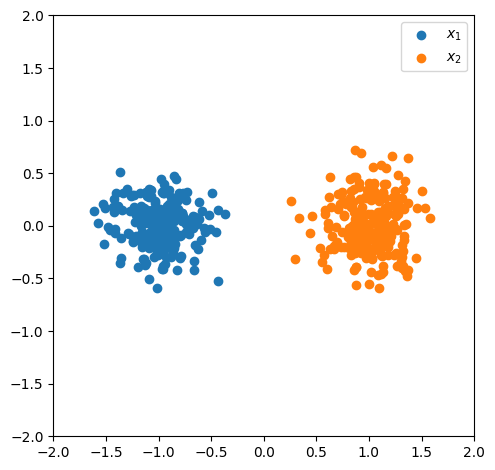

In [32]:
plt.scatter(X_1[:, 0], X_1[:, 1], label="$x_1$")
plt.scatter(X_2[:, 0], X_2[:, 1], label="$x_2$")
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

In [33]:
YX = np.diag(y_two_class) @ X_two_class
matA = np.block(
    [
        [np.eye(2), np.zeros((2, 1)), -YX.T],
        [np.zeros((1, 2)), np.zeros((1, 1)), y_two_class[None, :]],
        [YX, y_two_class[:, None], np.zeros((len(y_two_class), len(y_two_class)))],
    ]
)
matB = np.zeros((matA.shape[1]))
matB[-len(y_two_class) :] = 1.0

ans = np.linalg.solve(matA + np.eye(len(matA)) * 1.0e-4, matB)
a_ = ans[:2]
b_ = ans[2]

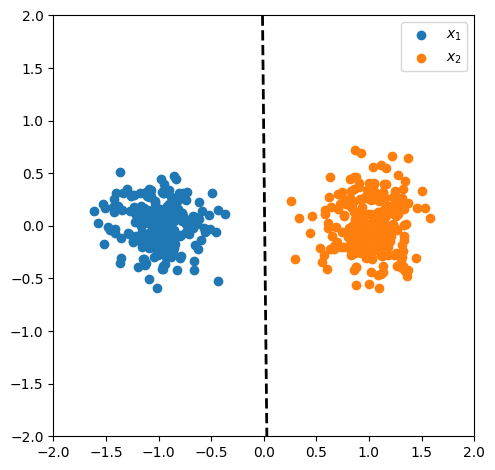

In [34]:
# サポートベクトルの端点を求める
x_min = -5
y_min = -1.0 * (a_[0] * x_min + b_) / a_[1]
x_max = +5
y_max = -1.0 * (a_[0] * x_max + b_) / a_[1]

# サポートベクトルの描画
# NOTE: 直線を描くとグラフの範囲がずれるので、直線を描く前の範囲を保存しておく
plt.scatter(X_1[:, 0], X_1[:, 1], label="$x_1$")
plt.scatter(X_2[:, 0], X_2[:, 1], label="$x_2$")
plt.axline((x_min, y_min), (x_max, y_max), color="black", linestyle="--", linewidth=2)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.legend()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

In [35]:
from sklearn.svm import SVC

# 訓練モデルの構築
clf = SVC(kernel="linear", C=1.0, tol=1.0e-2, max_iter=-1)
clf.fit(X, y)

SVC(kernel='linear', tol=0.01)

In [36]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Linear SVM: acc(train)={:.2f}%".format(acc_train))

Linear SVM: acc(train)=100.00%


In [37]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Linear SVM: acc(test)={:.2f}%".format(acc_test))

Linear SVM: acc(test)=90.50%


In [38]:
from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(500, noise=0.05, factor=0.5)

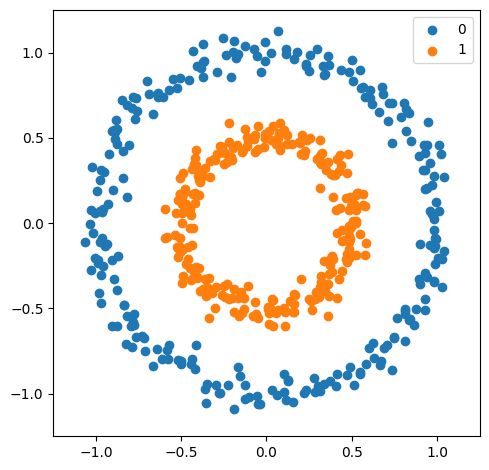

In [39]:
labels = ["$0$", "$1$"]
colors = ["tab:blue", "tab:orange"]
for i in range(len(labels)):
    idx = np.where(y_circ == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], c=colors[i], label=labels[i])
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
clf = SVC(kernel="linear", C=1.0, tol=1.0e-2, max_iter=-1)
clf.fit(X_circ, y_circ)

SVC(kernel='linear', tol=0.01)

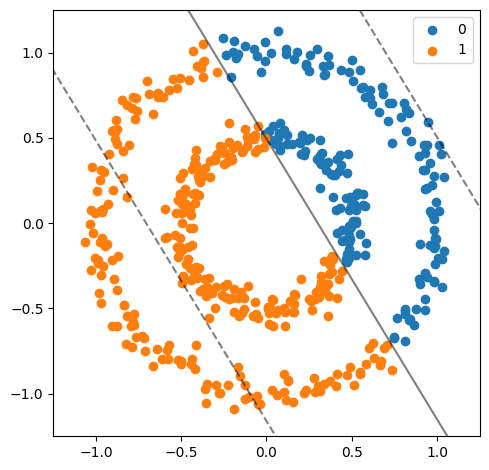

In [41]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_circ,
    ax=plt.gca(),
    colors="k",
    plot_method="contour",
    alpha=0.5,
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
)

y_pred = clf.predict(X_circ)
labels = ["$0$", "$1$"]
colors = ["tab:blue", "tab:orange"]
for i in range(len(labels)):
    idx = np.where(y_pred == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], c=colors[i], label=labels[i])

plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

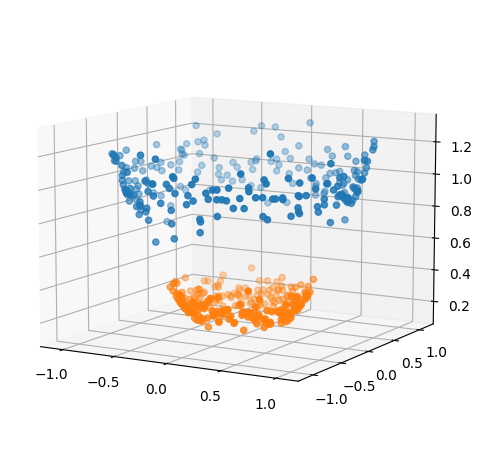

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.view_init(elev=10)

labels = ["$0$", "$1$"]
colors = ["tab:blue", "tab:orange"]
for i in range(len(labels)):
    idx = np.where(y_circ == i)
    ax.scatter(
        X_circ[idx, 0],
        X_circ[idx, 1],
        np.sum(X_circ[idx] ** 2, axis=1),
        c=colors[i],
        label=labels[i],
    )

plt.tight_layout()
plt.show()

In [43]:
clf = SVC(kernel="rbf", gamma=0.5, tol=1.0e-2, max_iter=-1)
clf.fit(X_circ, y_circ)

SVC(gamma=0.5, tol=0.01)

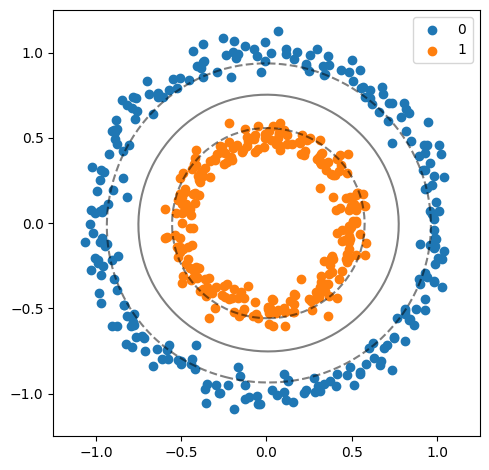

In [44]:
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_circ,
    ax=plt.gca(),
    colors="k",
    plot_method="contour",
    alpha=0.5,
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
)

y_pred = clf.predict(X_circ)
labels = ["$0$", "$1$"]
colors = ["tab:blue", "tab:orange"]
for i in range(len(labels)):
    idx = np.where(y_pred == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], c=colors[i], label=labels[i])

plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# 訓練モデルの構築
clf = SVC(kernel="rbf", gamma=0.5, tol=1.0e-2, max_iter=-1)
clf.fit(X, y)

SVC(gamma=0.5, tol=0.01)

In [46]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("RBF SVM: acc(train)={:.2f}%".format(acc_train))

RBF SVM: acc(train)=100.00%


In [47]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("RBF SVM: acc(test)={:.2f}%".format(acc_test))

RBF SVM: acc(test)=11.05%


In [48]:
# データセットを3つに分割
# 訓練: 50000, 検証: 10000, テスト: 10000
X, X_test, y, y_test = model_selection.train_test_split(
    X_org, y_org, train_size=60000, test_size=10000, shuffle=True
)

X, X_val, y, y_val = model_selection.train_test_split(
    X, y, train_size=50000, test_size=10000, shuffle=True
)

# 計算量を落とすため、訓練データの数を絞る
X, y = X[:n_samples], y[:n_samples]
X_val, y_val = X_val[:n_samples], y_val[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

In [49]:
import warnings
from itertools import product

from sklearn.exceptions import ConvergenceWarning

# グリッドサーチによる最適パラメータを探索
max_acc = 0.0
best_params = None

C_range = [0.01, 1.0, 100.0]
gamma_range = [0.1, 1.0, 10.0]
param_grid = {"C": C_range, "gamma": gamma_range}

for params in product(*param_grid.values()):
    param_dict = {list(param_grid.keys())[i]: v for i, v in enumerate(params)}
    clf = SVC(kernel="rbf", tol=1.0e-3, max_iter=50, **param_dict)

    # 収束が十分でない、という警告を無視
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf.fit(X, y)

    y_pred = clf.predict(X_val)
    acc_val = 100.0 * np.sum(y_pred == y_val) / len(y_val)
    print(param_dict)
    print("acc(val)={:.2f}%".format(acc_val))
    if max_acc < acc_val:
        max_acc = acc_val
        best_params = param_dict

{'C': 0.01, 'gamma': 0.1}
acc(val)=89.95%


{'C': 0.01, 'gamma': 1.0}
acc(val)=84.60%


{'C': 0.01, 'gamma': 10.0}
acc(val)=83.35%


{'C': 1.0, 'gamma': 0.1}
acc(val)=91.70%


{'C': 1.0, 'gamma': 1.0}
acc(val)=84.60%


{'C': 1.0, 'gamma': 10.0}
acc(val)=83.40%


{'C': 100.0, 'gamma': 0.1}
acc(val)=91.85%


{'C': 100.0, 'gamma': 1.0}
acc(val)=50.20%


{'C': 100.0, 'gamma': 10.0}
acc(val)=71.40%


In [50]:
print("Best param:", best_params)

Best param: {'C': 100.0, 'gamma': 0.1}


In [51]:
clf = SVC(kernel="rbf", tol=1.0e-2, max_iter=-1, **best_params)
clf.fit(X, y)

SVC(C=100.0, gamma=0.1, tol=0.01)

In [52]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Hold-out: acc(train)={:.2f}%".format(acc_train))

Hold-out: acc(train)=100.00%


In [53]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Hold-out: acc(test)={:.2f}%".format(acc_test))

Hold-out: acc(test)=81.05%


In [54]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

svm = SVC(tol=1.0e-3, max_iter=-1)

C_range = [0.01, 1.0, 100.0]
gamma_range = [0.1, 1.0, 10.0]
param_grid = {"C": C_range, "gamma": gamma_range}

clf = GridSearchCV(svm, param_grid, cv=4, n_jobs=8, verbose=2)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    ret = clf.fit(X, y)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


In [55]:
import pandas as pd
from IPython import display

df = pd.DataFrame.from_dict(ret.cv_results_)
df.drop(df.columns[:4], axis=1, inplace=True)
df.drop("params", axis=1, inplace=True)
display.display(df)

,param_C,param_gamma,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.1,0.110,0.110,0.110,0.110,0.1100,0.000000,5
1,0.01,1.0,0.110,0.110,0.110,0.110,0.1100,0.000000,5
2,0.01,10.0,0.110,0.110,0.110,0.110,0.1100,0.000000,5
3,1.0,0.1,0.748,0.792,0.748,0.718,0.7515,0.026396,2
4,1.0,1.0,0.124,0.122,0.118,0.116,0.1200,0.003162,4
5,1.0,10.0,0.110,0.110,0.110,0.110,0.1100,0.000000,5
6,100.0,0.1,0.758,0.806,0.776,0.738,0.7695,0.024995,1
7,100.0,1.0,0.132,0.124,0.126,0.130,0.1280,0.003162,3
8,100.0,10.0,0.110,0.110,0.110,0.110,0.1100,0.000000,5


In [56]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("CV: acc(train)={:.2f}%".format(acc_train))

CV: acc(train)=100.00%


In [57]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("CV: acc(test)={:.2f}%".format(acc_test))

CV: acc(test)=81.05%


In [58]:
import pickle

# バイト列を得る
serials = pickle.dumps(clf)

# バイト列の確認 (長いので最初の10バイトのみ確認)
print(serials[:10])

b'\x80\x04\x951#\x00\x00\x00\x00\x00'


In [59]:
# ファイルへの保存
with open("rbf_svm.pickle", "wb") as f:
    f.write(serials)

In [60]:
# 再読み込みとテスト
clf2 = None
with open("rbf_svm.pickle", "rb") as f:
    clf2 = pickle.loads(f.read())

y_pred = clf2.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("CV: acc(test)={:.2f}%".format(acc_test))

CV: acc(test)=81.05%


In [61]:
import pandas as pd
from IPython import display

html_text = """
<table style="width: 80%;">
    <thead>
        <tr>
            <th></th>
            <th></th>
            <th style="text-align:center;" colspan="2">正解</td>
        </tr>
    </thead>
    <tr>
        <td style="width: 25%; text-align: center;"></td>
        <td style="width: 25%; text-align: center;"></td>
        <td style="width: 25%; text-align: center;">病気である</td>
        <td style="width: 25%; text-align: center;">病気でない</td>
    </tr>
    <tr>
        <td rowspan="2" style="background: white; text-align: center;">
            <span style="font-weight: bold;">予想</span>
        </td>
        <td style="width: 25%; text-align: center;">病気である</td>
        <td style="width: 25%; text-align: center;">正陽性 (TP)</td>
        <td style="width: 25%; text-align: center;">偽陽性 (FP)</td>
    </tr>
    <tr>
        <td style="width: 25%; text-align: center;">病気でない</td>
        <td style="width: 25%; text-align: center;">偽陰性 (FN)</td>
        <td style="width: 25%; text-align: center;">偽陽性 (TN)</td>
    </tr>
</table>
"""

display.HTML(html_text)

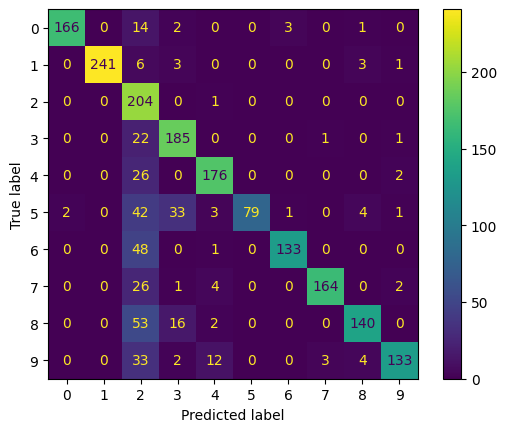

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=plt.gca())
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix

# 混同行列の計算
y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)

In [64]:
# マクロ平均の計算
P_k = np.diag(C) / np.sum(C, axis=0)
R_k = np.diag(C) / np.sum(C, axis=1)
F_k = (2.0 * P_k * R_k) / (P_k + R_k)
macro_P = np.mean(P_k)
macro_R = np.mean(R_k)
macro_F = np.mean(F_k)
print("macro-P={:.5f}".format(macro_P))
print("macro-R={:.5f}".format(macro_R))
print("macro-F={:.5f}".format(macro_F))

macro-P=0.88854
macro-R=0.80011
macro-F=0.81712


In [65]:
# マイクロ平均の計算
micro_avg = np.sum(np.diag(C)) / np.sum(C)
print("micro-avg={:.5f}".format(micro_avg))

micro-avg=0.81050
